# Imports

In [1]:
# from factor_analyzer import (ConfirmatoryFactorAnalyzer, ModelSpecificationParser)    

# model_dict = {"F1": ["V1", "V2", "V3", "V4"], "F2": ["V5", "V6", "V7", "V8"]}

# model_spec = ModelSpecificationParser.parse_model_specification_from_dict(df, model_dict)

# cfa = ConfirmatoryFactorAnalyzer(model_spec, disp=False) 

# cfa.fit(df.values) 

# cfa.loadings_ 

In [2]:
import numpy as np
import os
import pandas as pd
import plotnine as gg
gg.theme_set(gg.theme_classic)
import sklearn.decomposition as skdec
import statsmodels.formula.api as smf

In [3]:
from Functions import get_ages_cols, get_param_names, get_category_dict, get_category_from_feature, name_from_index, bool_from_index, get_quantile_groups

## Directories etc.

In [4]:
data_save_path = "C:/Users/maria/MEGAsync/SLCNdata/Meta/all_data"
plot_save_path = "C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots"
if not os.path.exists(plot_save_path):
    os.makedirs(plot_save_path)

# Get data

In [5]:
all_data = pd.read_csv(os.path.join(data_save_path, 'all_data.csv'), index_col=0)
all_data_z = pd.read_csv(os.path.join(data_save_path, 'all_data_z.csv'), index_col=0)
all_data_long = pd.read_csv(os.path.join(data_save_path, 'all_data_long.csv'), index_col=0)
all_data_long_z = pd.read_csv(os.path.join(data_save_path, 'all_data_long_z.csv'), index_col=0)

In [6]:
print("Number of features: {}".format(len(np.unique(all_data_long_z['feature']))))

Number of features: 55


In [7]:
ages_dir = "C:/Users/maria/MEGAsync/SLCNdata/SLCNinfo2.csv"
ages = pd.read_csv(os.path.join(ages_dir))

In [8]:
ages_cols = get_ages_cols()
param_names = get_param_names()
category_dict = get_category_dict()

In [9]:
n_comp = 9  # How many PCA components?
feature_pc_scalar = 5  # How much should we exagerate the differences between positive and negative directions in pc in features?

# Dimensionality reduction (PCA)

In [108]:
# Run PCA
def run_pca(pca_dat):
    
    pca = skdec.PCA(n_components=pca_dat.shape[1])
    # pca = KernelPCA(n_components=z_dat.shape[1])
    fit = pca.fit_transform(pca_dat)
    
    return pca, fit

def run_fa(pca_dat):
    
    fa = skdec.FactorAnalysis()
    fit = fa.fit_transform(pca_dat)
    
    return fa, fit

# Run PCA on all data
ids_all = all_data_z.drop(columns=ages_cols[1:]).dropna(axis=1).ID
pca_dat_all = all_data_z.drop(columns=ages_cols).dropna(axis=1)
pca_all, fit_all = run_pca(pca_dat_all)
fa_all, fit_all_fa = run_fa(pca_dat_all)

# Run PCA on behavior only
param_cols = []
for col in all_data_z.columns:
    for param_name in param_names:
        if param_name in col:
            param_cols += [col]

ids_beh = all_data_z.drop(columns=ages_cols[1:] + param_cols).dropna(axis=1).ID
pca_dat_beh = all_data_z.drop(columns=ages_cols + param_cols).dropna(axis=1)
pca_beh, fit_beh = run_pca(pca_dat_beh)

# Run PCA on params only
ids_par = all_data_z[param_cols + ['ID']].dropna(axis=1).ID
pca_dat_par = all_data_z[param_cols].dropna(axis=1)
pca_par, fit_par = run_pca(pca_dat_par)

In [113]:
fa_pd = pd.DataFrame(fa_all.components_, columns=[pca_dat_all.columns])
fa_pd.head()

,bf_ACC,bf_RT,bf_RTsd,bf_miss,rl_ACC,rl_RT,rl_RTsd,rl_miss,ps_ACC,ps_RT,...,rl_lrn_pinc_sig,ps_n_switches,ps_WLS,ps_criterion_trial,bf_ACC_first3trials,bf_asymptote,bf_learning_slope,bf_intercept,bf_prew,bf_delay
0,-0.798115,0.314317,0.414121,0.060273,-0.641156,0.438475,0.404585,0.411465,-0.431389,0.499417,...,0.213523,-0.222322,-0.631768,-0.398319,-0.296551,-0.810494,-0.236383,-0.839596,-0.771549,0.412745
1,0.351964,-0.093323,-0.136164,-0.168230,0.186597,-0.174610,-0.180073,-0.150982,-0.599517,-0.008050,...,-0.107878,-0.366824,-0.635489,-0.308571,0.121923,0.334852,0.091982,0.331078,0.230330,0.037885
2,0.240505,0.121438,0.157269,0.070305,-0.576428,0.373430,0.345129,0.287331,0.041942,0.280668,...,0.291015,0.152738,-0.028939,-0.023056,0.106694,0.259113,-0.072115,0.299718,0.308031,-0.101253
3,0.022061,0.383060,0.385644,0.167083,0.198663,0.453789,0.457788,0.066746,-0.405604,0.281079,...,-0.029014,-0.306423,0.207100,0.428754,0.016610,0.001827,0.032551,0.012780,-0.009535,-0.059116
4,-0.037778,0.397084,0.410233,-0.014175,0.134450,0.428697,0.400593,-0.075656,0.175911,0.130385,...,-0.003590,0.106899,-0.173950,-0.148440,-0.065847,-0.031570,-0.010479,-0.027818,-0.006345,-0.052248


In [114]:
# Flip the signs of FAs1-n based on the sign of FA0 (same preprocessing as for PCs)
for i in range(1, len(fa_pd) - 1):
    fa_pd.iloc[i] *= np.sign(fa_pd.iloc[0])
    
fa_pd.head()

,bf_ACC,bf_RT,bf_RTsd,bf_miss,rl_ACC,rl_RT,rl_RTsd,rl_miss,ps_ACC,ps_RT,...,rl_lrn_pinc_sig,ps_n_switches,ps_WLS,ps_criterion_trial,bf_ACC_first3trials,bf_asymptote,bf_learning_slope,bf_intercept,bf_prew,bf_delay
0,-0.798115,0.314317,0.414121,0.060273,-0.641156,0.438475,0.404585,0.411465,-0.431389,0.499417,...,0.213523,-0.222322,-0.631768,-0.398319,-0.296551,-0.810494,-0.236383,-0.839596,-0.771549,0.412745
1,-0.351964,-0.093323,-0.136164,-0.168230,-0.186597,-0.174610,-0.180073,-0.150982,0.599517,-0.008050,...,-0.107878,0.366824,0.635489,0.308571,-0.121923,-0.334852,-0.091982,-0.331078,-0.230330,0.037885
2,-0.240505,0.121438,0.157269,0.070305,0.576428,0.373430,0.345129,0.287331,-0.041942,0.280668,...,0.291015,-0.152738,0.028939,0.023056,-0.106694,-0.259113,0.072115,-0.299718,-0.308031,-0.101253
3,-0.022061,0.383060,0.385644,0.167083,-0.198663,0.453789,0.457788,0.066746,0.405604,0.281079,...,-0.029014,0.306423,-0.207100,-0.428754,-0.016610,-0.001827,-0.032551,-0.012780,0.009535,-0.059116
4,0.037778,0.397084,0.410233,-0.014175,-0.134450,0.428697,0.400593,-0.075656,-0.175911,0.130385,...,-0.003590,-0.106899,0.173950,0.148440,0.065847,0.031570,0.010479,0.027818,0.006345,-0.052248


In [115]:
fa_long = pd.melt(fa_pd[:3], ignore_index=False, var_name='feature', value_name='loading')#, id_vars=['Factor_ID', ])
fa_long = fa_long.reset_index().rename(columns={'index': 'FID'})
fa_long['task'] = fa_long['feature'].apply(lambda x : x[:2])
fa_long

,FID,feature,loading,task
0,0,bf_ACC,-0.798115,bf
1,1,bf_ACC,-0.351964,bf
2,2,bf_ACC,-0.240505,bf
3,0,bf_RT,0.314317,bf
4,1,bf_RT,-0.093323,bf
...,...,...,...,...
157,1,bf_prew,-0.230330,bf
158,2,bf_prew,-0.308031,bf
159,0,bf_delay,0.412745,bf
160,1,bf_delay,0.037885,bf


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 18 x 12 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3FALoadings.svg
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\guides\guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 18 x 12 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3FALoadings.png
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\guides\guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it
C:\Users\maria\Ana

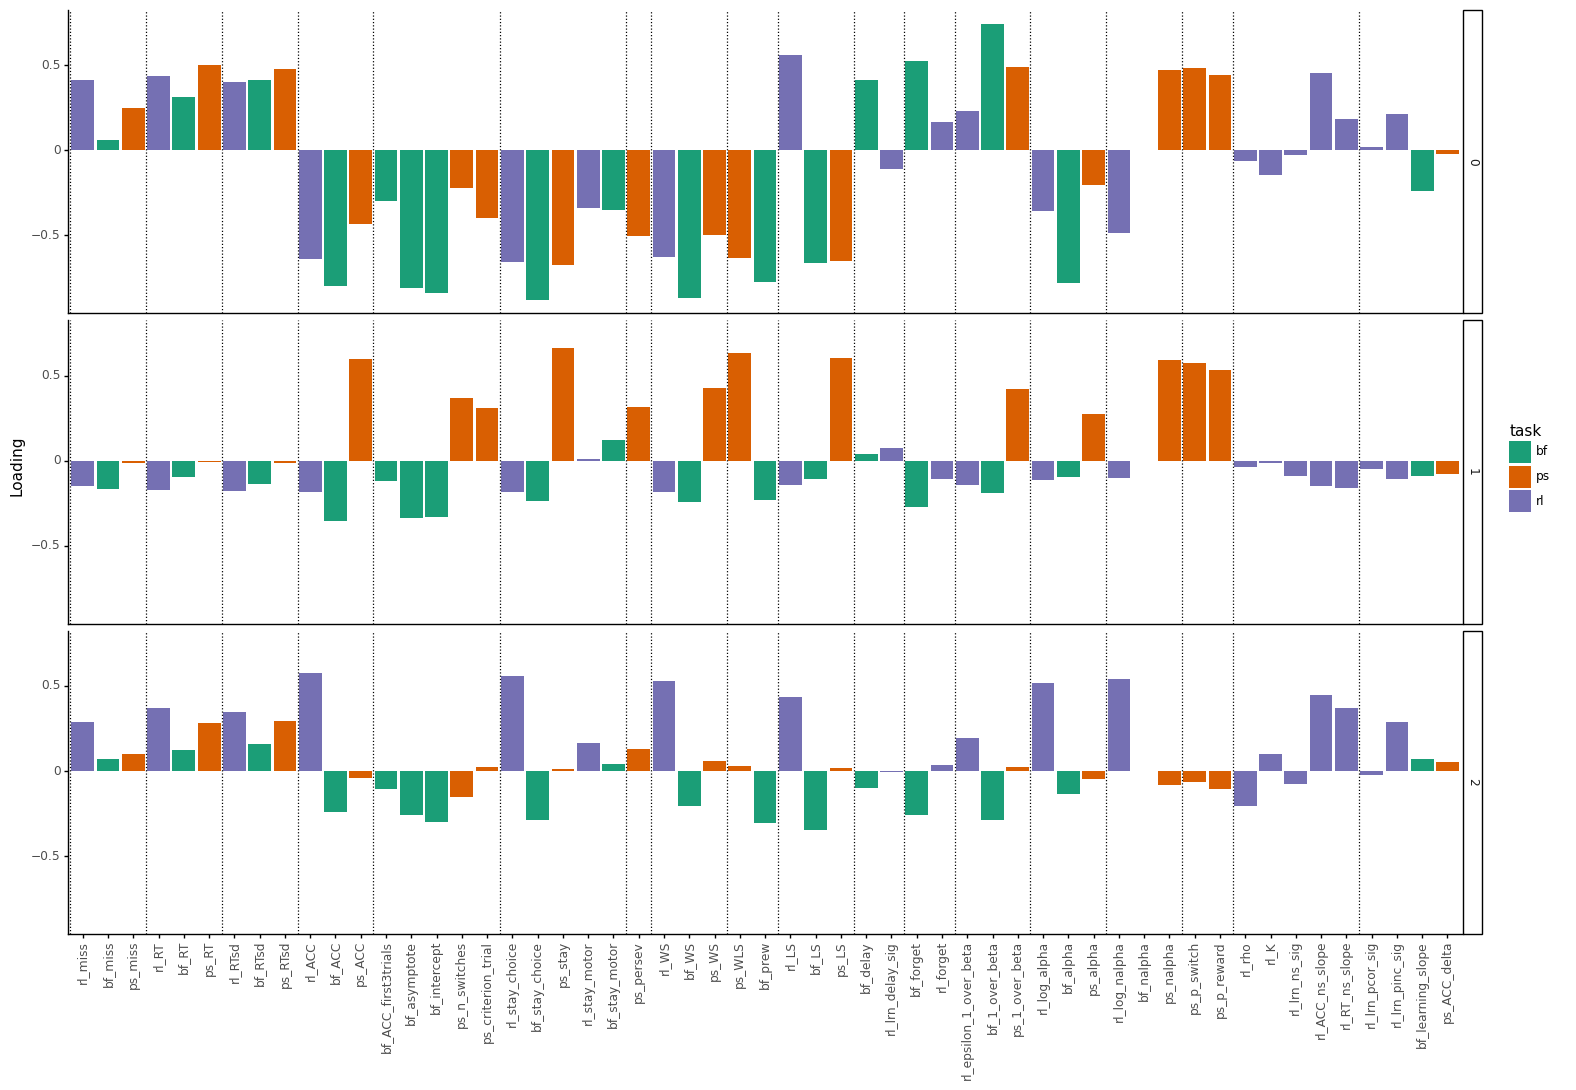

<ggplot: (152503721213)>


In [117]:
gg.options.figure_size = (18, 12)
g = (gg.ggplot(fa_long, gg.aes('feature', 'loading', fill='task'))
 + gg.geom_bar(stat='identity')
 + gg.scale_x_discrete(limits=x_ticks)
 + gg.scales.scale_color_brewer(type='qual', palette=2)
 + gg.scales.scale_fill_brewer(type='qual', palette=2)
 + gg.geom_vline(xintercept=x_lines, linetype='dotted')
 + gg.theme(axis_text_x=gg.element_text(rotation=90, hjust=0.5))
 + gg.labs(x='', y='Loading')
 + gg.facet_grid('FID ~')
)

g.save(os.path.join(plot_save_path, '3FALoadings.svg'))
g.save(os.path.join(plot_save_path, '3FALoadings.png'))
print(g)

Explained variance at 1 components: 34.7%.


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 4 x 4 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3_PCAExplainedVarianceAll.png
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 4 x 4 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3_PCAExplainedVarianceAll.svg


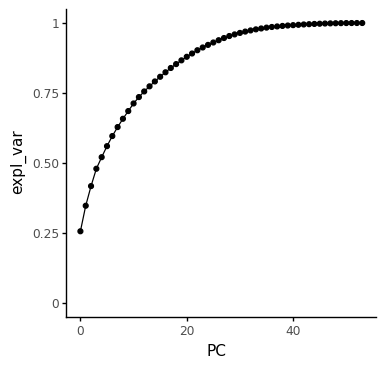

<ggplot: (152491573751)>
Explained variance at 1 components: 36.7%.


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 4 x 4 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3_PCAExplainedVarianceBeh.png
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 4 x 4 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3_PCAExplainedVarianceBeh.svg


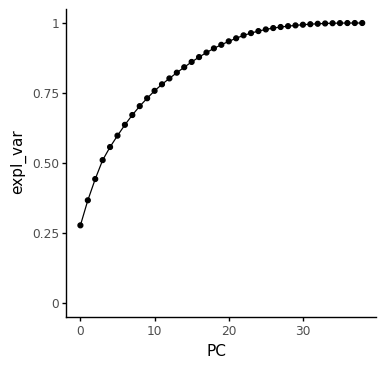

<ggplot: (152491697402)>
Explained variance at 1 components: 37.0%.


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 4 x 4 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3_PCAExplainedVariancePar.png
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 4 x 4 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3_PCAExplainedVariancePar.svg


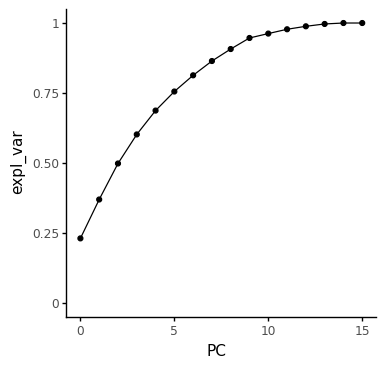

<ggplot: (152491765565)>


,PC,expl_var
0,0,0.256206
1,1,0.347429
2,2,0.417604
3,3,0.479548
4,4,0.520844
5,5,0.560238
6,6,0.596283
7,7,0.628357
8,8,0.658000
9,9,0.685528


In [11]:
# Plot explained variance
def plot_expl_var(pca_dat, pca, name, n_comp=1):
    
    expl_var_dat = pd.DataFrame({'PC': range(pca_dat.shape[1]), 'expl_var': np.cumsum(pca.explained_variance_ratio_)})
    expl_var_at_n_comp = list(expl_var_dat[expl_var_dat.PC <= n_comp].expl_var)[-1]
    print("Explained variance at {} components: {}%.".format(n_comp, round(100 * expl_var_at_n_comp, 1)))

    g = (gg.ggplot(expl_var_dat, gg.aes('PC', 'expl_var'))
         + gg.geom_point()
         + gg.geom_line()
         + gg.coord_cartesian(ylim=(0, 1))
    #      + gg.geom_hline(yintercept=1, linetype='dashed')
    #      + gg.geom_hline(yintercept=expl_var_at_n_comp, linetype='dotted')
    #      + gg.geom_vline(xintercept=n_comp, linetype='dotted')
    )
    g.save(os.path.join(plot_save_path, '3_PCAExplainedVariance{}.png'.format(name)))
    g.save(os.path.join(plot_save_path, '3_PCAExplainedVariance{}.svg'.format(name)))
    print(g)
    
    return expl_var_dat
    
# Explained variance all behaviors
gg.options.figure_size = (4, 4)
d = plot_expl_var(pca_dat_all, pca_all, 'All')
plot_expl_var(pca_dat_beh, pca_beh, 'Beh')
plot_expl_var(pca_dat_par, pca_par, 'Par')
d

In [12]:
def create_fit_pd(fit, pca_dat, ids, ages_sub, n_comp=n_comp):
    
    # fit_pd
    fit_pd = pd.DataFrame(fit,
                          columns=['pc{}'.format(i) for i in range(pca_dat.shape[1])],
                          index=ids)
    fit_pd = fit_pd.reset_index()
    fit_pd = fit_pd.merge(ages_sub)

    return fit_pd#, fit_pd_long

# Create fit_pd's
ages_sub = ages[['ID', 'PreciseYrs', 'BMI', 'Gender', 'meanT', 'PDS']]
fit_pd_all = create_fit_pd(fit_all, pca_dat_all, ids_all, ages_sub)
fit_pd_beh = create_fit_pd(fit_beh, pca_dat_beh, ids_beh, ages_sub)
fit_pd_par = create_fit_pd(fit_par, pca_dat_par, ids_par, ages_sub)

# Save as csv
fit_pd_all.to_csv(os.path.join(data_save_path, 'fit_pd_all.csv'))
fit_pd_beh.to_csv(os.path.join(data_save_path, 'fit_pd_beh.csv'))
fit_pd_par.to_csv(os.path.join(data_save_path, 'fit_pd_par.csv'))

In [13]:
fit_pd_all = pd.read_csv(os.path.join(data_save_path, 'fit_pd_all.csv'))
fit_pd_beh = pd.read_csv(os.path.join(data_save_path, 'fit_pd_beh.csv'))
fit_pd_par = pd.read_csv(os.path.join(data_save_path, 'fit_pd_par.csv'))


def make_fit_pd_long(fit_pd):

    return fit_pd.melt(
        value_vars=['pc{}'.format(i) for i in range(n_comp)],
        id_vars=['ID', 'PreciseYrs', 'BMI', 'Gender', 'meanT', 'PDS'])

fit_pd_long_all = make_fit_pd_long(fit_pd_all)
fit_pd_long_beh = make_fit_pd_long(fit_pd_beh)
fit_pd_long_par = make_fit_pd_long(fit_pd_par)

C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 4 x 4 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3_Pc0Pc1_Age_All.png
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 4 x 4 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3_Pc2Pc3_Age_All.png
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 4 x 4 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3_Pc0Pc1_PDS_All.png
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 4 x 4 in 

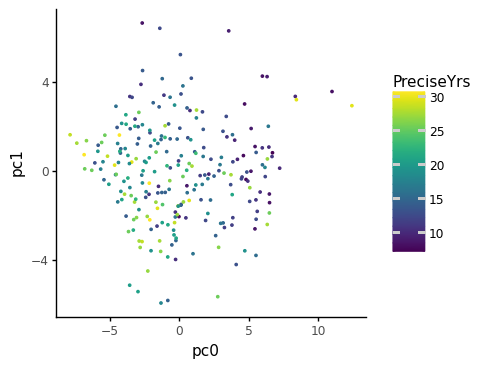

<ggplot: (152493460071)>


In [14]:
# Age in PC space
def plot_age_in_pc_space(fit_pd, name):
    
    g1 = (gg.ggplot(fit_pd, gg.aes('pc0', 'pc1', color='PreciseYrs'))
     + gg.geom_point(size=0.5)
    )
    g1.save(os.path.join(plot_save_path, '3_Pc0Pc1_Age_{}.png'.format(name)))

    g2 = g1 + gg.aes('pc2', 'pc3')
    g2.save(os.path.join(plot_save_path, '3_Pc2Pc3_Age_{}.png'.format(name)))
    
    g3 = g1 + gg.aes(color='PDS')
    g3.save(os.path.join(plot_save_path, '3_Pc0Pc1_PDS_{}.png'.format(name)))

    g4 = g1 + gg.aes(color='meanT')
    g4.save(os.path.join(plot_save_path, '3_Pc0Pc1_T_{}.png'.format(name)))
    
    print(g1)

# Run on all measures
plot_age_in_pc_space(fit_pd_all, 'All')
# plot_age_in_pc_space(fit_pd_beh, 'Beh')
# plot_age_in_pc_space(fit_pd_par, 'Par')

In [15]:
fit_pd_long_all['age_group'] = get_quantile_groups(fit_pd_long_all, 'PreciseYrs')[0]
fit_pd_long_all['age_group_'] = pd.Categorical(fit_pd_long_all.age_group.replace({0.25: '08-10', 0.5: '10-13', 0.75: '13-15', 1: '15-17', 2: '2Stud.', 3: '3Adult'}), ordered=True)
fit_pd_long_all

,ID,PreciseYrs,BMI,Gender,meanT,PDS,variable,value,age_group,age_group_
0,17,8.657084,18.200751,2.0,NaN,2.50,pc0,6.499028,0.25,08-10
1,18,12.637919,16.157863,2.0,NaN,2.25,pc0,-2.092134,0.50,10-13
2,20,14.543463,17.433768,1.0,120.649667,2.80,pc0,-4.190911,0.75,13-15
3,22,16.490075,22.709959,1.0,147.334443,3.00,pc0,1.728768,1.00,15-17
4,23,11.206023,15.147686,1.0,27.712900,1.00,pc0,0.487961,0.50,10-13
...,...,...,...,...,...,...,...,...,...,...
2218,465,22.333333,NaN,2.0,NaN,NaN,pc8,1.278604,2.00,2Stud.
2219,466,20.083333,NaN,1.0,NaN,NaN,pc8,-1.780854,2.00,2Stud.
2220,467,18.750000,NaN,2.0,NaN,NaN,pc8,1.588191,2.00,2Stud.
2221,468,21.833333,NaN,2.0,NaN,NaN,pc8,2.282310,2.00,2Stud.


In [16]:
fit_pd_long_beh['age_group'] = get_quantile_groups(fit_pd_long_beh, 'PreciseYrs')[0]
fit_pd_long_beh['age_group_'] = pd.Categorical(fit_pd_long_beh.age_group.replace({0.25: '08-10', 0.5: '10-13', 0.75: '13-15', 1: '15-17', 2: '2Stud.', 3: '3Adult'}), ordered=True)
fit_pd_long_beh

,ID,PreciseYrs,BMI,Gender,meanT,PDS,variable,value,age_group,age_group_
0,17,8.657084,18.200751,2.0,NaN,2.50,pc0,5.339678,0.25,08-10
1,18,12.637919,16.157863,2.0,NaN,2.25,pc0,-1.823044,0.50,10-13
2,20,14.543463,17.433768,1.0,120.649667,2.80,pc0,-3.823409,0.75,13-15
3,22,16.490075,22.709959,1.0,147.334443,3.00,pc0,1.506866,1.00,15-17
4,23,11.206023,15.147686,1.0,27.712900,1.00,pc0,-0.079802,0.50,10-13
...,...,...,...,...,...,...,...,...,...,...
2218,465,22.333333,NaN,2.0,NaN,NaN,pc8,-0.097889,2.00,2Stud.
2219,466,20.083333,NaN,1.0,NaN,NaN,pc8,-0.212061,2.00,2Stud.
2220,467,18.750000,NaN,2.0,NaN,NaN,pc8,-0.542345,2.00,2Stud.
2221,468,21.833333,NaN,2.0,NaN,NaN,pc8,-1.924489,2.00,2Stud.


In [17]:
fit_pd_long_par['age_group'] = get_quantile_groups(fit_pd_long_par, 'PreciseYrs')[0]
fit_pd_long_par['age_group_'] = pd.Categorical(fit_pd_long_par.age_group.replace({0.25: '08-10', 0.5: '10-13', 0.75: '13-15', 1: '15-17', 2: '2Stud.', 3: '3Adult'}), ordered=True)
fit_pd_long_par

,ID,PreciseYrs,BMI,Gender,meanT,PDS,variable,value,age_group,age_group_
0,17,8.657084,18.200751,2.0,NaN,2.50,pc0,3.894660,0.25,08-10
1,18,12.637919,16.157863,2.0,NaN,2.25,pc0,-0.929928,0.50,10-13
2,20,14.543463,17.433768,1.0,120.649667,2.80,pc0,-1.894836,0.75,13-15
3,22,16.490075,22.709959,1.0,147.334443,3.00,pc0,0.924011,1.00,15-17
4,23,11.206023,15.147686,1.0,27.712900,1.00,pc0,1.199609,0.50,10-13
...,...,...,...,...,...,...,...,...,...,...
2218,465,22.333333,NaN,2.0,NaN,NaN,pc8,-0.229155,2.00,2Stud.
2219,466,20.083333,NaN,1.0,NaN,NaN,pc8,-0.350454,2.00,2Stud.
2220,467,18.750000,NaN,2.0,NaN,NaN,pc8,-0.635056,2.00,2Stud.
2221,468,21.833333,NaN,2.0,NaN,NaN,pc8,0.060168,2.00,2Stud.


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 10 x 8 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3_PcsOverAgeAll.png
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\stats\smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\facets\facet.py:549: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\facets\facet.py:555: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'
C:\Users\maria\Anaconda3\envs\notebooks

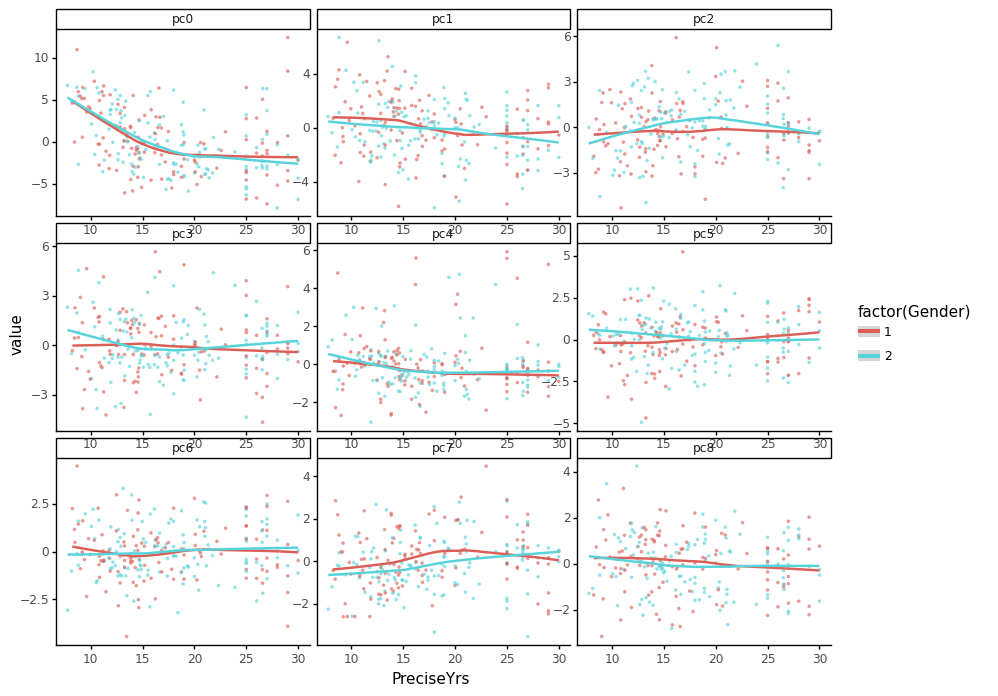

<ggplot: (152491815087)>


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 10 x 8 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3_PcsOverTAll.png
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\stats\smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\facets\facet.py:549: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\facets\facet.py:555: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'
C:\Users\maria\Anaconda3\envs\notebooks\l

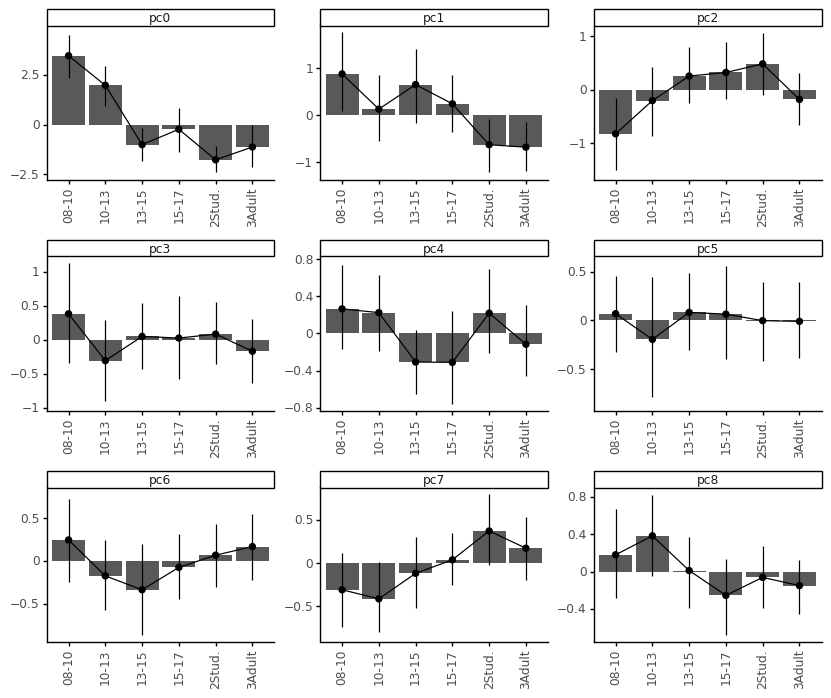

<ggplot: (152494699331)>


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 10 x 8 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3_PcsOverAgeGroupAll.png
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 10 x 8 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3_PcsOverAgeGroupAll.svg


In [18]:
# PC changes over age
def plot_pcs_over_age(fit_pd_long, name):
    
    gg.options.figure_size = (10, 8)
    g = (gg.ggplot(fit_pd_long, gg.aes('PreciseYrs', 'value', color='factor(Gender)'))
     + gg.geom_point(alpha=0.5, size=0.5)
     + gg.geom_smooth()
     + gg.facet_wrap('~ variable', scales='free')
    )
    g.save(os.path.join(plot_save_path, '3_PcsOverAge{}.png'.format(name)))
    print(g)
    
    g_t = g + gg.aes(x='meanT')
    g_t.save(os.path.join(plot_save_path, '3_PcsOverT{}.png'.format(name)))
    
    g_pds = g + gg.aes(x='PDS')
    g_pds.save(os.path.join(plot_save_path, '3_PcsOverPDS{}.png'.format(name)))
    
    g_group = (
        gg.ggplot(fit_pd_long, gg.aes('age_group_', 'value', group=1)) # , fill='age_group_', fill='factor(Gender)', group='factor(Gender)'
        + gg.stat_summary(geom='bar', position=gg.position_dodge(width=0.2))
        + gg.stat_summary(geom='line', position=gg.position_dodge(width=0.2))
        + gg.stat_summary(position=gg.position_dodge(width=0.2))
        + gg.labs(x='', y='', fill='')
        + gg.theme(axis_text_x=gg.element_text(rotation=90, hjust=0.5))
        + gg.theme(subplots_adjust={'hspace': 0.5, 'wspace': 0.2})
        + gg.theme(legend_position='none')
        + gg.facet_wrap('~ variable', scales='free')
    )
    print(g_group)
    g_group.save(os.path.join(plot_save_path, '3_PcsOverAgeGroup{}.png'.format(name)))
    g_group.save(os.path.join(plot_save_path, '3_PcsOverAgeGroup{}.svg'.format(name)))
    
# Plot all
plot_pcs_over_age(fit_pd_long_all, 'All')
# plot_pcs_over_age(fit_pd_long_beh, 'Beh')
# plot_pcs_over_age(fit_pd_long_par, 'Par')

In [19]:
# Stats on PC age effects
for pc in ['pc0', 'pc1', 'pc2']:
    mod = smf.ols('{} ~ PreciseYrs + np.square(PreciseYrs)'.format(pc), data=fit_pd_all).fit()
    print('\n', pc, mod.summary())


 pc0                             OLS Regression Results                            
Dep. Variable:                    pc0   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                     39.79
Date:                Sun, 03 Apr 2022   Prob (F-statistic):           1.11e-15
Time:                        22:29:39   Log-Likelihood:                -639.58
No. Observations:                 247   AIC:                             1285.
Df Residuals:                     244   BIC:                             1296.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               

In [20]:
# Factor loadings
choice_param_cols = []
update_param_cols = []
for col in all_data.columns:
    if ('beta' in col) or ('epsilon' in col) or ('forget' in col):
        choice_param_cols += [col]
    if 'alpha' in col:
        update_param_cols += [col]

In [21]:
def add_signed_pcs(loadings, pref=''):
    
    signs = np.sign(loadings['pc0'])
    for pc in ['pc{}'.format(i) for i in range(n_comp)]:
        loadings['{}{}'.format(pref, pc)] = loadings[pc] * signs
    return loadings

# # Example use
# add_signed_pcs(loadings_all)

In [22]:
def create_loadings_long(pca, pca_dat, n_comp=n_comp):
    
    loadings = pca.components_[:n_comp].T  # (n_components, n_features)
    loadings_pd = pd.DataFrame(loadings, columns=['pc{}'.format(i) for i in range(n_comp)], index=pca_dat.columns)
    loadings_pd = loadings_pd.reset_index().rename(columns={'index': 'feature'})
    loadings_pd = add_signed_pcs(loadings_pd, 'ref_')
    loadings_long = loadings_pd.melt(
#         value_vars=['pc{}'.format(i) for i in range(n_comp)],
        id_vars=['feature'])
    
    loadings_long['task'] = loadings_long['feature'].apply(lambda x : x[:2])
    loadings_long['ACC_RT'] = loadings_long['feature'].apply(name_from_index, names=['ACC', 'RT'])
    loadings_long['category'] = get_category_from_feature(loadings_long['feature'], category_dict)
    loadings_long['param_bool'] = loadings_long['feature'].apply(bool_from_index, names=param_cols)
    loadings_long['PC'] = loadings_long['variable'].apply(lambda x : int(x[-1]))
    loadings_long['ref'] = loadings_long['variable'].apply(lambda x : 'ref' in x)
#     loadings_long['pc<0>'] = loadings_long['value'].apply(lambda x: 'pc>0' if x > 0 else 'pc<0')

    for param in choice_param_cols:
        loadings_long.loc[loadings_long['feature'] == param, 'category'] = 'choice_param'
    for param in update_param_cols:
        loadings_long.loc[loadings_long['feature'] == param, 'category'] = 'update_param'
    
    return loadings_long, loadings_pd

# All
loadings_long_all, loadings_all = create_loadings_long(pca_all, pca_dat_all)
loadings_long_beh, loadings_beh = create_loadings_long(pca_beh, pca_dat_beh)
loadings_long_par, loadings_par = create_loadings_long(pca_par, pca_dat_par)

In [23]:
loadings_long_all.loc[loadings_long_all['variable'] == 'pc0']

,feature,variable,value,task,ACC_RT,category,param_bool,PC,ref
0,bf_ACC,pc0,-0.203552,bf,ACC,ACC,False,0,False
1,bf_RT,pc0,0.097153,bf,RT,RT,False,0,False
2,bf_RTsd,pc0,0.124789,bf,RT,RTsd,False,0,False
3,bf_miss,pc0,0.020812,bf,None,miss,False,0,False
4,rl_ACC,pc0,-0.185070,rl,ACC,ACC,False,0,False
5,rl_RT,pc0,0.135282,rl,RT,RT,False,0,False
6,rl_RTsd,pc0,0.124919,rl,RT,RTsd,False,0,False
7,rl_miss,pc0,0.121749,rl,None,miss,False,0,False
8,ps_ACC,pc0,-0.121272,ps,ACC,ACC,False,0,False
9,ps_RT,pc0,0.150853,ps,RT,RT,False,0,False


In [24]:
# Save as csv
# loadings_long_all.to_csv(os.path.join(data_save_path, 'loadings_long_all.csv'))
# loadings_long_beh.to_csv(os.path.join(data_save_path, 'loadings_long_beh.csv'))
# loadings_long_par.to_csv(os.path.join(data_save_path, 'loadings_long_par.csv'))

loadings_long_all = pd.read_csv(os.path.join(data_save_path, 'loadings_long_all.csv'))
loadings_long_beh = pd.read_csv(os.path.join(data_save_path, 'loadings_long_beh.csv'))
loadings_long_par = pd.read_csv(os.path.join(data_save_path, 'loadings_long_par.csv'))

C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 18 x 12 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3PCALoadings.svg
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\guides\guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 18 x 12 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3PCALoadings.png
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\guides\guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it
C:\Users\maria\A

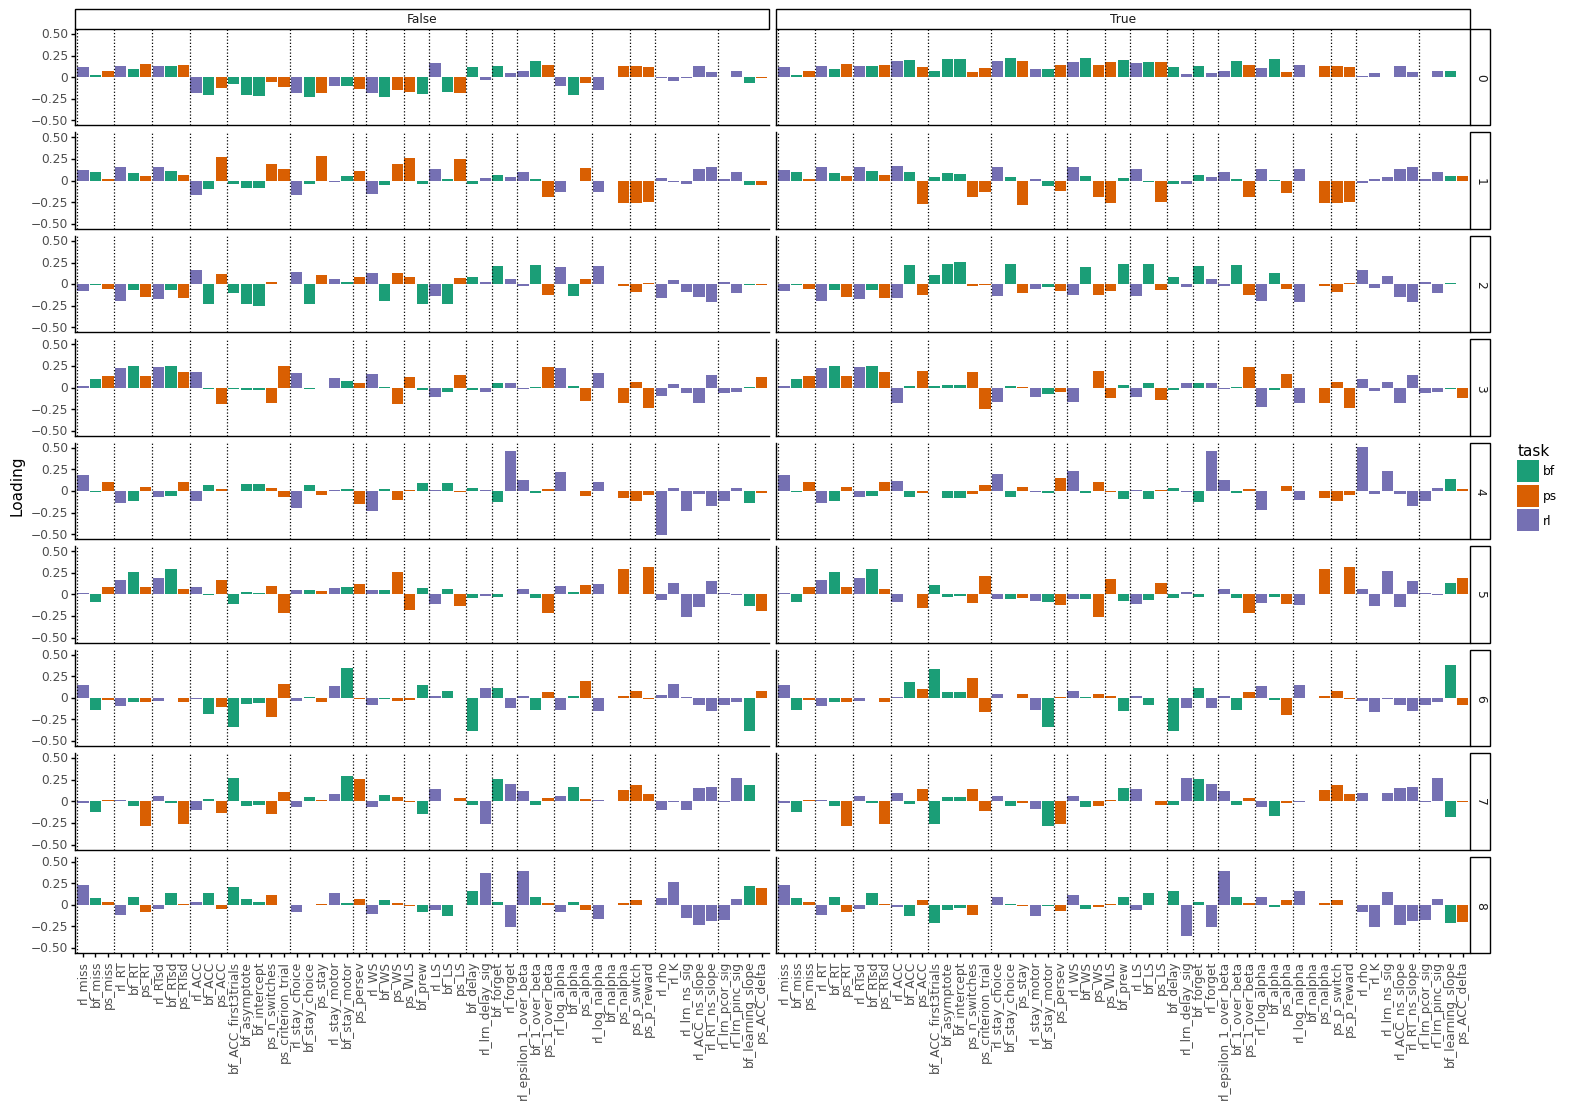

<ggplot: (152491846253)>


In [25]:
x_ticks = []
x_lines = []
x = 0.5
for features in category_dict.values():
    x_ticks += features
    x_lines += [x]
    x += len(features)

gg.options.figure_size = (18, 12)
g = (gg.ggplot(loadings_long_all, gg.aes('feature', 'value', fill='task'))
     + gg.geom_bar(stat='identity')
     + gg.scale_x_discrete(limits=x_ticks)
     + gg.scales.scale_color_brewer(type='qual', palette=2)
     + gg.scales.scale_fill_brewer(type='qual', palette=2)
     + gg.geom_vline(xintercept=x_lines, linetype='dotted')
     + gg.theme(axis_text_x=gg.element_text(rotation=90, hjust=0.5))
     + gg.labs(x='', y='Loading')
     + gg.facet_grid('PC ~ ref')
    )
g.save(os.path.join(plot_save_path, '3PCALoadings.svg'))
g.save(os.path.join(plot_save_path, '3PCALoadings.png'))
print(g)

C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 18 x 12 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3PCALoadings_beh_par_sep.svg
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\guides\guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\guides\guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


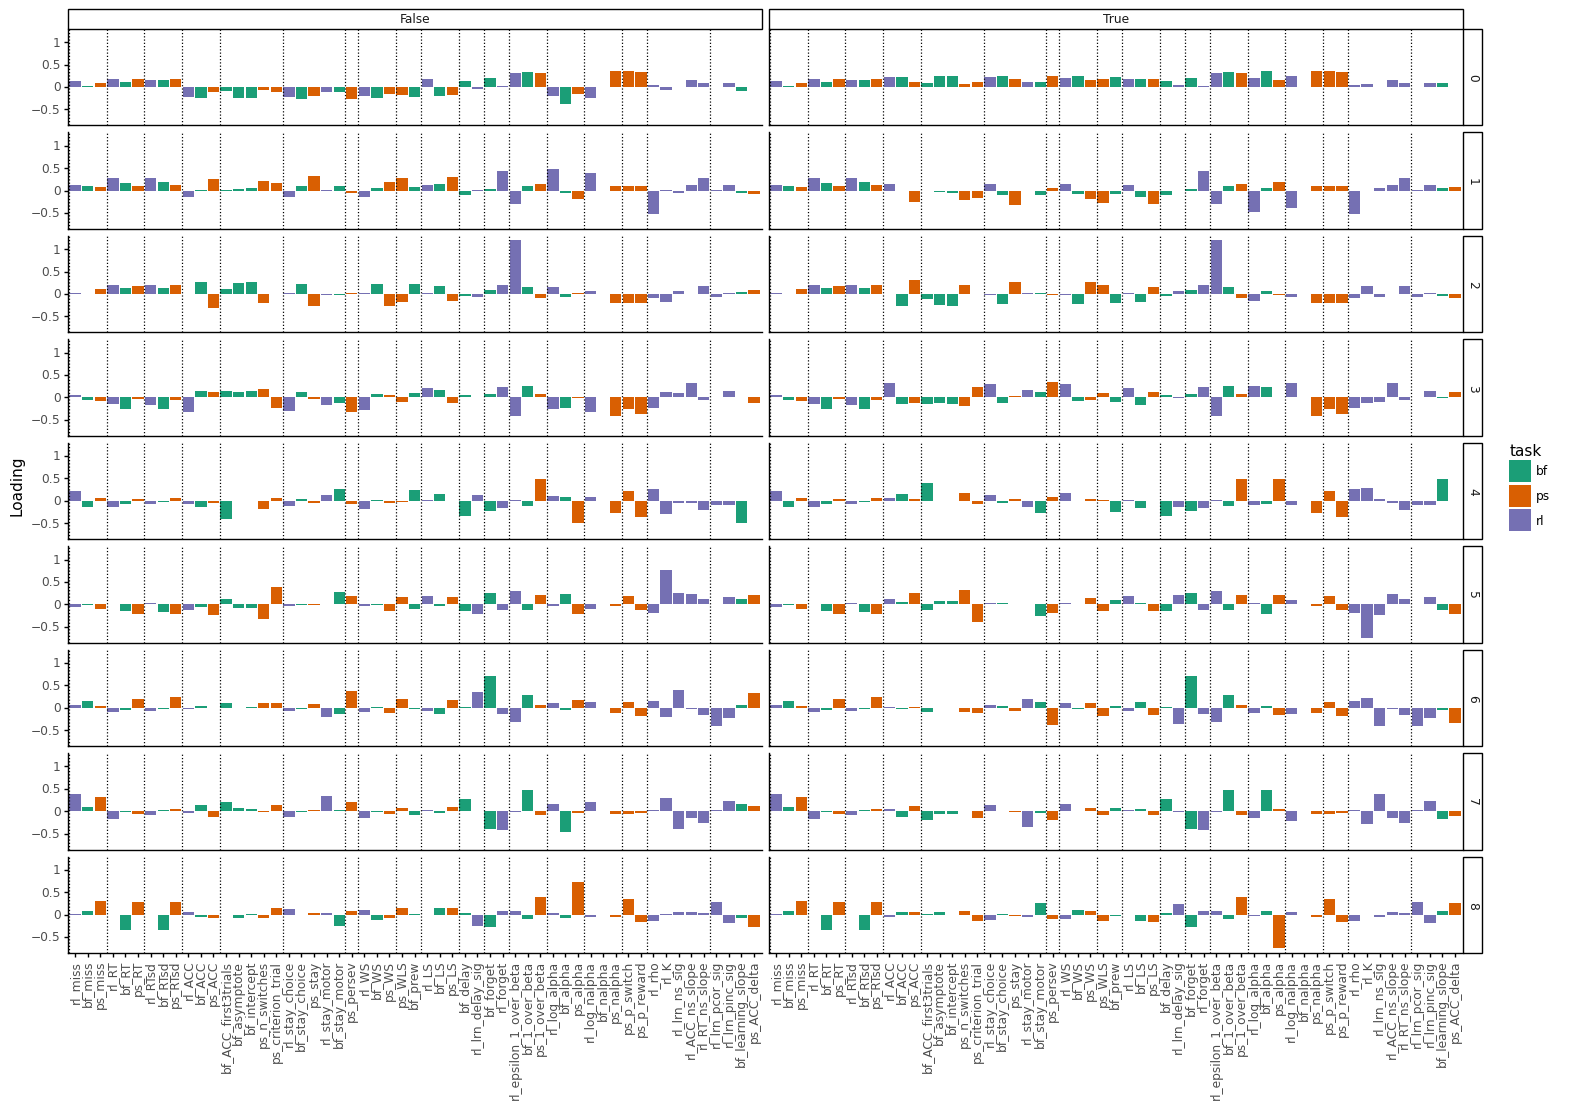

<ggplot: (152500001160)>


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 18 x 12 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3PCALoadings_beh_par_sep.png
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\guides\guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


In [26]:
g = (gg.ggplot(pd.concat([loadings_long_beh, loadings_long_par]), gg.aes('feature', 'value', fill='task'))
     + gg.geom_bar(stat='identity')
     + gg.scale_x_discrete(limits=x_ticks)
     + gg.scales.scale_color_brewer(type='qual', palette=2)
     + gg.scales.scale_fill_brewer(type='qual', palette=2)
     + gg.geom_vline(xintercept=x_lines, linetype='dotted')
     + gg.theme(axis_text_x=gg.element_text(rotation=90, hjust=0.5))
     + gg.labs(x='', y='Loading')
     + gg.facet_grid('PC ~ ref')
    )
g.save(os.path.join(plot_save_path, '3PCALoadings_beh_par_sep.svg'))
print(g)
g.save(os.path.join(plot_save_path, '3PCALoadings_beh_par_sep.png'))

In [27]:
def plot_loadings(loadings_long, name, n_comp=n_comp):

    if 'beh_only' in name:
        sub_dat = loadings_long[(loadings_long['PC'] < n_comp) & np.invert(loadings_long['param_bool'])]
    elif 'par_only' in name:
        sub_dat = loadings_long[(loadings_long['PC'] < n_comp) & (loadings_long['param_bool'])]
    else:
        sub_dat = loadings_long[loadings_long['PC'] < n_comp]

    gg.options.figure_size = (10, 8)
    g = (gg.ggplot(sub_dat, gg.aes('feature', 'value', fill='category'))
         + gg.geom_bar(stat='identity')
         + gg.theme(axis_text_x=gg.element_text(rotation=90, hjust=0.5))
         + gg.facet_grid('variable ~ task + ref', scales='free_x')
         + gg.labs(x='', y='Loading')
    )
    g.save(os.path.join(plot_save_path, '3_PCALoadings_{}.png'.format(name)))
    print(g)
    
# # Plot
# plot_loadings(loadings_long_all, 'All_beh_only')
# plot_loadings(loadings_long_all, 'All_par_only')
# plot_loadings(loadings_long_all, 'All')
# plot_loadings(loadings_long_beh, 'Beh')
# plot_loadings(loadings_long_par, 'Par')

In [28]:
# Plot behavioral and parameter PCs against each other
fit_pd_behpar = pd.merge(fit_pd_long_beh, fit_pd_long_par, on=['ID', 'PreciseYrs', 'BMI', 'Gender', 'meanT', 'PDS'] + ["ID"], suffixes=("_beh", "_par"))
fit_pd_behpar

,ID,PreciseYrs,BMI,Gender,meanT,PDS,variable_beh,value_beh,age_group_beh,age_group__beh,variable_par,value_par,age_group_par,age_group__par
0,17,8.657084,18.200751,2.0,NaN,2.5,pc0,5.339678,0.25,08-10,pc0,3.894660,0.25,08-10
1,17,8.657084,18.200751,2.0,NaN,2.5,pc0,5.339678,0.25,08-10,pc1,0.151365,0.25,08-10
2,17,8.657084,18.200751,2.0,NaN,2.5,pc0,5.339678,0.25,08-10,pc2,0.184791,0.25,08-10
3,17,8.657084,18.200751,2.0,NaN,2.5,pc0,5.339678,0.25,08-10,pc3,-0.328923,0.25,08-10
4,17,8.657084,18.200751,2.0,NaN,2.5,pc0,5.339678,0.25,08-10,pc4,0.309779,0.25,08-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20002,469,19.000000,NaN,2.0,NaN,NaN,pc8,0.765193,2.00,2Stud.,pc4,-0.292123,2.00,2Stud.
20003,469,19.000000,NaN,2.0,NaN,NaN,pc8,0.765193,2.00,2Stud.,pc5,1.665842,2.00,2Stud.
20004,469,19.000000,NaN,2.0,NaN,NaN,pc8,0.765193,2.00,2Stud.,pc6,0.896689,2.00,2Stud.
20005,469,19.000000,NaN,2.0,NaN,NaN,pc8,0.765193,2.00,2Stud.,pc7,0.880031,2.00,2Stud.


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\stats\smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


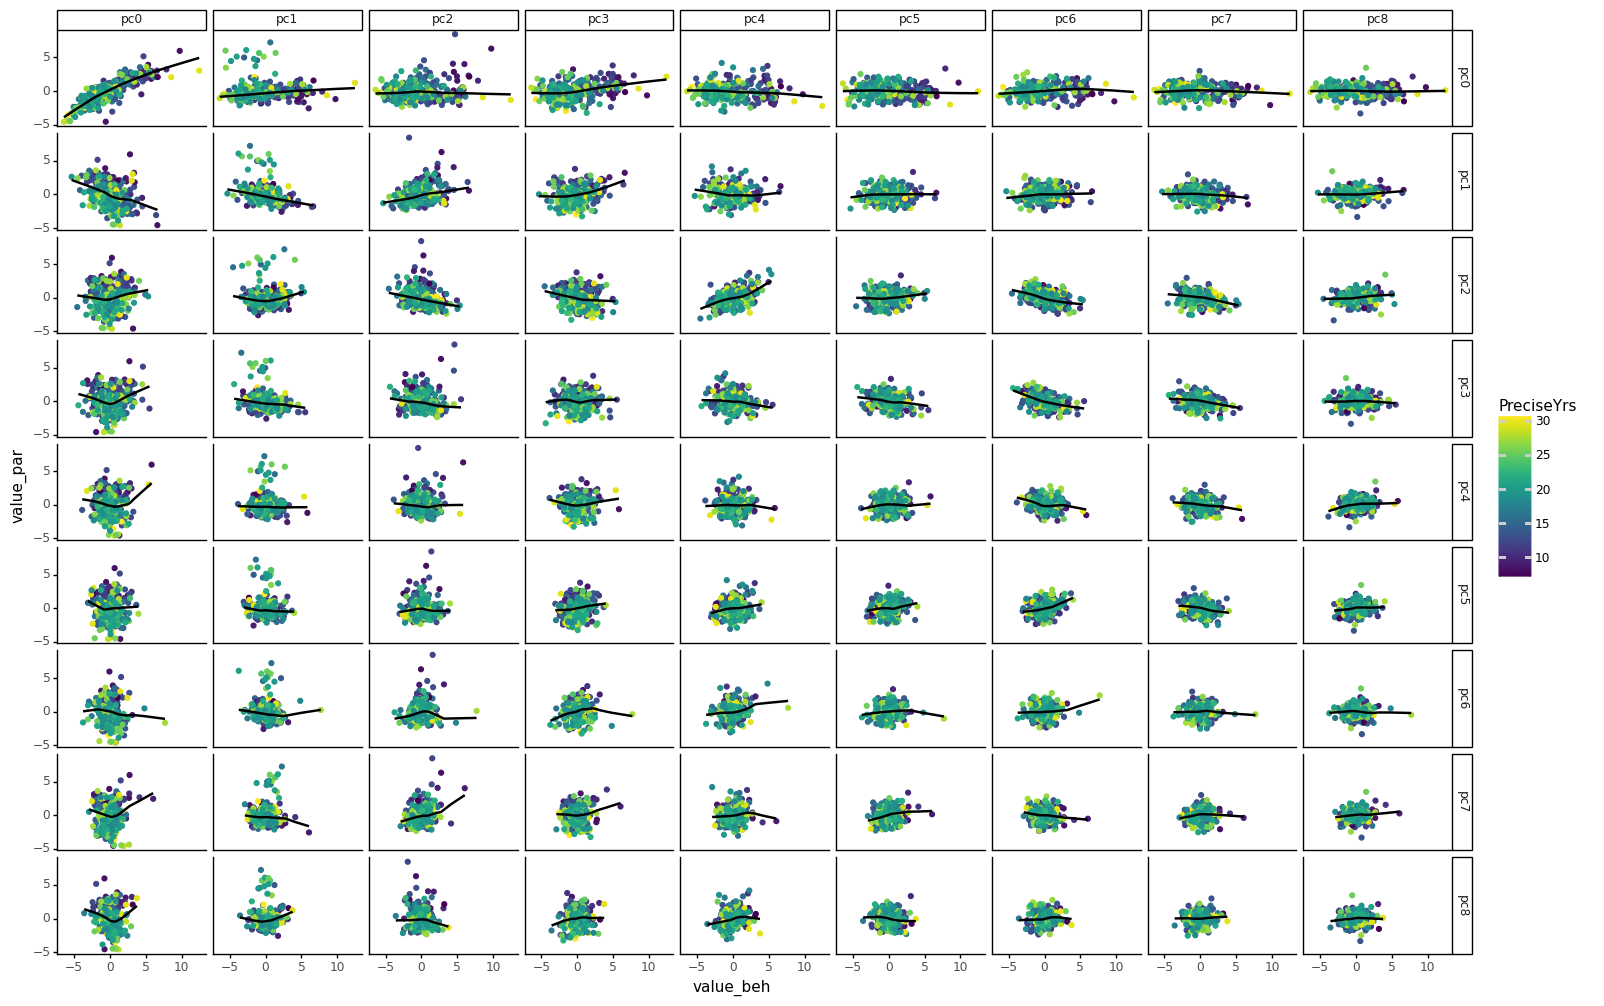

<ggplot: (152497321153)>


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 18 x 12 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3_PcsBehVersusPcsPar.png
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\stats\smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


In [29]:
gg.options.figsize = (20, 20)
g = (gg.ggplot(fit_pd_behpar, gg.aes("value_beh", "value_par", color='PreciseYrs'))
     + gg.geom_point()
     + gg.geom_smooth()
     + gg.facet_grid("variable_beh ~ variable_par")
    )
print(g)
g.save(os.path.join(plot_save_path, '3_PcsBehVersusPcsPar.png'))

## Plot average behavior for big / small values of each PC

In [30]:
feature_means = all_data_long[['feature', 'value']].groupby(['feature']).aggregate('mean').reset_index().rename(columns={'value': 'feature_mean'})
feature_means['category'] = get_category_from_feature(feature_means['feature'], category_dict)
feature_means

,feature,feature_mean,category
0,bf_1_over_beta,0.095496,Beta
1,bf_ACC,0.773526,ACC
2,bf_ACC_first3trials,0.564103,ACC2
3,bf_LS,0.593543,LS
4,bf_RT,1.196378,RT
5,bf_RTsd,0.653729,RTsd
6,bf_WS,0.830999,WS
7,bf_alpha,0.216508,Alpha
8,bf_asymptote,0.836014,ACC2
9,bf_delay,-0.165125,Delay


In [31]:
feature_means_pcs = pd.merge(feature_means, loadings_all)

for pc in ['pc{}'.format(i) for i in range(n_comp)]:
    feature_means_pcs['feature_{}+'.format(pc)] = feature_means_pcs.feature_mean + feature_pc_scalar * feature_means_pcs[pc]
    feature_means_pcs['feature_{}-'.format(pc)] = feature_means_pcs.feature_mean - feature_pc_scalar * feature_means_pcs[pc]

feature_means_pcs

,feature,feature_mean,category,pc0,pc1,pc2,pc3,pc4,pc5,pc6,...,feature_pc4+,feature_pc4-,feature_pc5+,feature_pc5-,feature_pc6+,feature_pc6-,feature_pc7+,feature_pc7-,feature_pc8+,feature_pc8-
0,bf_1_over_beta,0.095496,Beta,0.192564,0.019894,0.225570,0.012512,-0.021961,-0.043815,-0.141212,...,-0.014310,0.205301,-0.123578,0.314569,-0.610566,0.801557,-0.130645,0.321636,0.542534,-0.351543
1,bf_ACC,0.773526,ACC,-0.203552,-0.099711,-0.226594,-0.015242,0.066060,-0.007553,-0.188427,...,1.103826,0.443226,0.735760,0.811292,-0.168608,1.715660,0.915958,0.631093,1.430044,0.117008
2,bf_ACC_first3trials,0.564103,ACC2,-0.077024,-0.037449,-0.103960,-0.017688,0.001662,-0.112660,-0.336737,...,0.572411,0.555794,0.000804,1.127401,-1.119581,2.247786,1.880529,-0.752324,1.602327,-0.474121
3,bf_LS,0.593543,LS,-0.171149,0.019723,-0.227984,-0.051687,0.096773,0.063455,0.085776,...,1.077407,0.109679,0.910815,0.276270,1.022423,0.164663,0.604075,0.583011,-0.066994,1.254079
4,bf_RT,1.196378,RT,0.097153,0.083593,-0.071947,0.246430,-0.115080,0.252628,-0.043810,...,0.620978,1.771778,2.459519,-0.066763,0.977330,1.415426,0.906113,1.486643,1.616943,0.775813
5,bf_RTsd,0.653729,RTsd,0.124789,0.107399,-0.071539,0.247292,-0.063234,0.287967,-0.006130,...,0.337558,0.969900,2.093564,-0.786106,0.623077,0.684381,0.525630,0.781828,1.347773,-0.040315
6,bf_WS,0.830999,WS,-0.225453,-0.052450,-0.194302,0.005887,0.027862,0.053664,-0.008673,...,0.970310,0.691687,1.099319,0.562678,0.787633,0.874364,1.169799,0.492198,1.082619,0.579378
7,bf_alpha,0.216508,Alpha,-0.205793,-0.003611,-0.133772,0.022633,-0.004600,0.025975,0.023804,...,0.193506,0.239510,0.346384,0.086632,0.335527,0.097489,1.032634,-0.599619,0.335729,0.097287
8,bf_asymptote,0.836014,ACC2,-0.207203,-0.086585,-0.229060,-0.025564,0.078197,0.025462,-0.065517,...,1.226998,0.445031,0.963326,0.708703,0.508431,1.163598,0.583297,1.088731,1.160131,0.511897
9,bf_delay,-0.165125,Delay,0.115294,-0.044197,0.082609,-0.033094,0.036896,-0.037518,-0.386452,...,0.019357,-0.349606,-0.352715,0.022466,-2.097385,1.767136,-0.378657,0.048407,0.670121,-1.000370


In [32]:
feature_means_pcs_long = feature_means_pcs.melt(id_vars=['feature', 'feature_mean', 'category'])
feature_means_pcs_long['feat_pc'] = feature_means_pcs_long.variable.apply(lambda x : 'feat' if 'feature' in x else 'pc')
feature_means_pcs_long = feature_means_pcs_long.loc[feature_means_pcs_long.feat_pc == 'feat']
feature_means_pcs_long['plus_minus'] = feature_means_pcs_long.variable.apply(lambda x : x[-1:])
feature_means_pcs_long['pc'] = feature_means_pcs_long.variable.apply(lambda x : x[-2])
feature_means_pcs_long['shape'] = feature_means_pcs_long.apply(lambda x : 'o' if x.plus_minus == '+' else ('^' if x.value > x.feature_mean else 'v'), axis=1)
feature_means_pcs_long

,feature,feature_mean,category,variable,value,feat_pc,plus_minus,pc,shape
972,bf_1_over_beta,0.095496,Beta,feature_pc0+,1.058315,feat,+,0,o
973,bf_ACC,0.773526,ACC,feature_pc0+,-0.244237,feat,+,0,o
974,bf_ACC_first3trials,0.564103,ACC2,feature_pc0+,0.178983,feat,+,0,o
975,bf_LS,0.593543,LS,feature_pc0+,-0.262202,feat,+,0,o
976,bf_RT,1.196378,RT,feature_pc0+,1.682142,feat,+,0,o
...,...,...,...,...,...,...,...,...,...
1939,rl_lrn_pinc_sig,0.542057,Learn,feature_pc8-,0.183668,feat,-,8,v
1940,rl_miss,0.001194,miss,feature_pc8-,-1.133482,feat,-,8,v
1941,rl_rho,0.840768,WM,feature_pc8-,0.426683,feat,-,8,v
1942,rl_stay_choice,0.762556,Stay,feature_pc8-,1.183369,feat,-,8,^


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 25 x 10 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3_BehaviorPlusMinus5PCs.png
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\scales\scale_alpha.py:68: PlotnineWarning: Using alpha for a discrete variable is not advised.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\scales\scale_alpha.py:68: PlotnineWarning: Using alpha for a discrete variable is not advised.


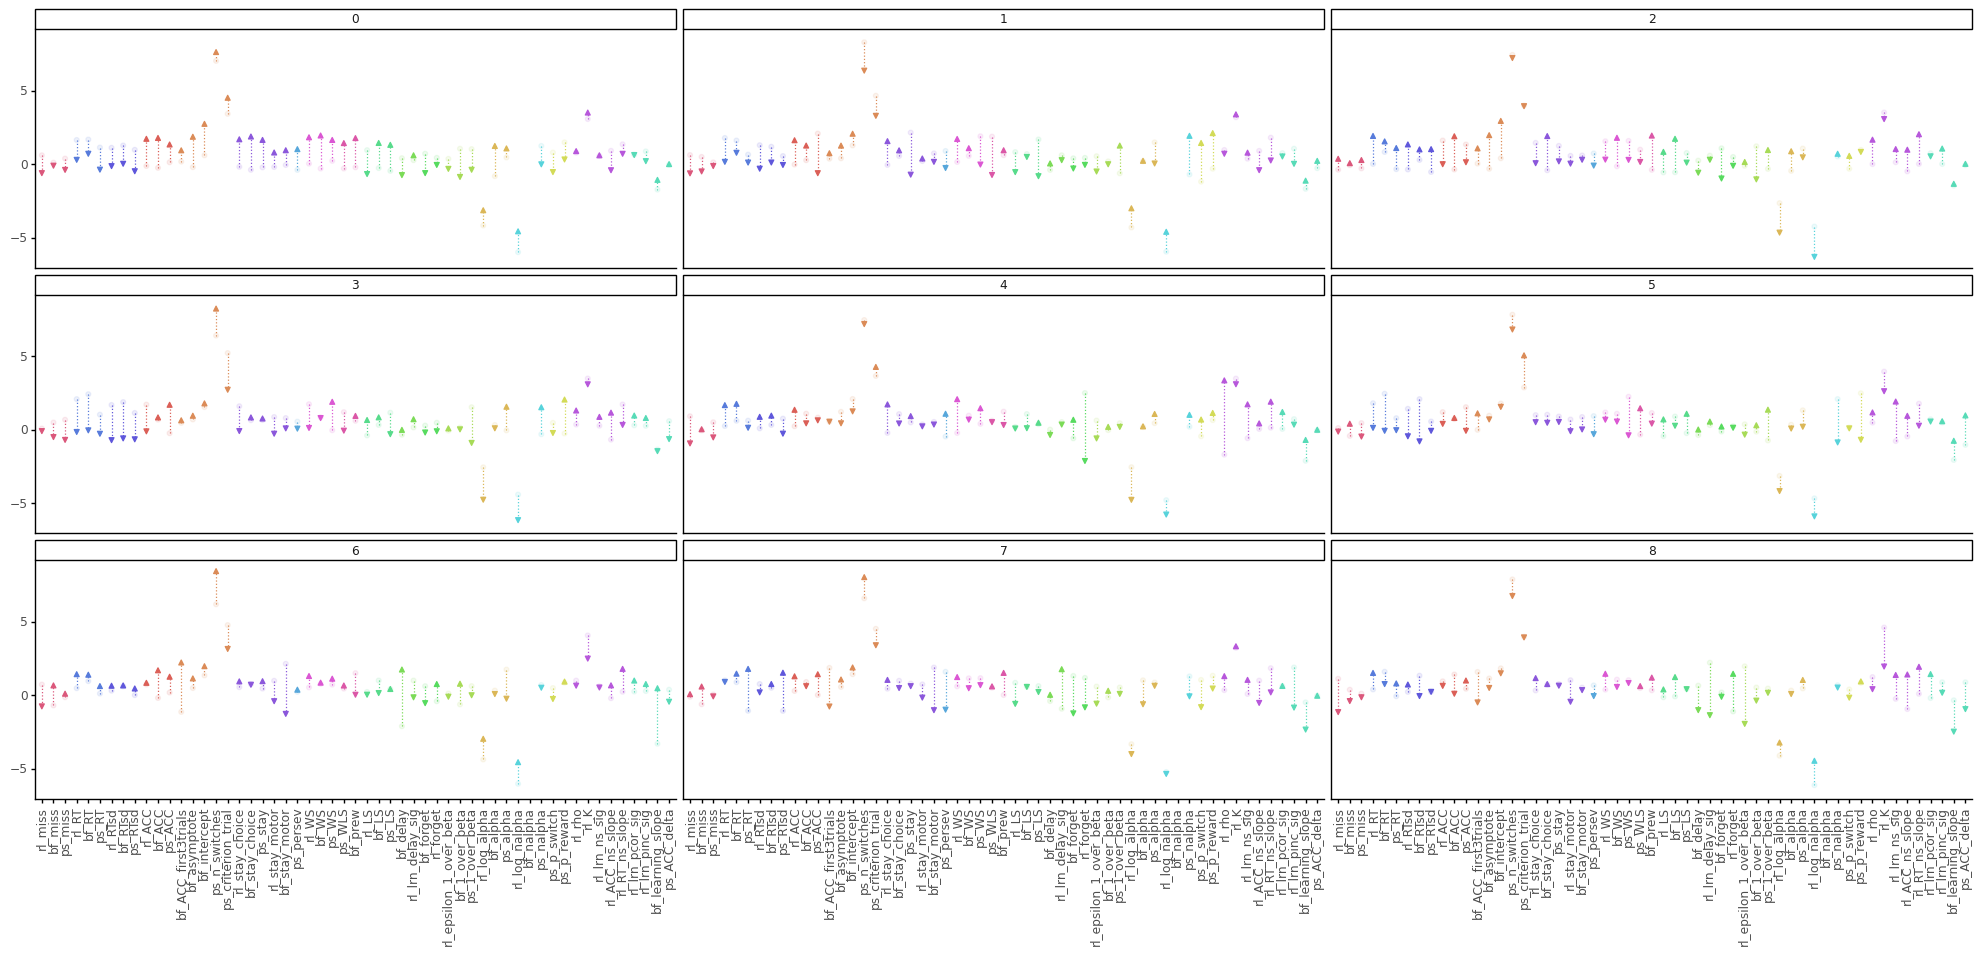

<ggplot: (152493708930)>


In [33]:
# Plot average behaviors for big (+) and small (-) values of each PC
# gg.options.figure_size = (18, 10)
gg.options.figure_size = (25, 10)
g = (gg.ggplot(feature_means_pcs_long, gg.aes('feature', 'value', color='category',
                                              shape='shape', alpha='plus_minus'))
     + gg.geom_point()
     + gg.geom_line(gg.aes(group='feature'), linetype='dotted', alpha=1)
     + gg.scale_shape_manual(values=('^', 'o', 'v'))
     + gg.scale_x_discrete(limits=x_ticks)
     + gg.theme(legend_position='none')
     + gg.labs(x='', y='')
     + gg.theme(axis_text_x=gg.element_text(rotation=90, hjust=0.5))
#      + gg.facet_grid('pc ~ plus_minus')
     + gg.facet_wrap('~ pc')
    )
g.save(os.path.join(plot_save_path, '3_BehaviorPlusMinus{}PCs.png'.format(feature_pc_scalar)))
print(g)

## Same for derived behaviors
e.g., RT + RT_delta; RT - RT_delta; RLWM accuracy with ns slope; etc. for PC+ and PC-

### RT early vs late

In [34]:
feature_cols = [c for c in feature_means_pcs.columns if 'feature_pc' in c]

RTs = feature_means_pcs.loc[feature_means_pcs['feature'].isin(['ps_RT', 'bf_RT', 'rl_RT']), feature_cols + ['feature']].reset_index(drop=True)
task = RTs['feature'].apply(lambda x : x[:2])
RTs = RTs.drop(columns='feature')

RT_delta = feature_means_pcs.loc[feature_means_pcs['feature'].isin(['ps_RT_delta', 'bf_RT_delta', 'rl_RT_delta']), feature_cols].reset_index(drop=True)

RT_early, RT_late = RTs + RT_delta / 2, RTs - RT_delta / 2
RT_early['feature'], RT_late['feature'] = 'RT_early', 'RT_late'
RT_early['task'], RT_late['task'] = task, task

RT_early_late = RT_early.append(RT_late)
RT_early_late

,feature_pc0+,feature_pc0-,feature_pc1+,feature_pc1-,feature_pc2+,feature_pc2-,feature_pc3+,feature_pc3-,feature_pc4+,feature_pc4-,feature_pc5+,feature_pc5-,feature_pc6+,feature_pc6-,feature_pc7+,feature_pc7-,feature_pc8+,feature_pc8-,feature,task
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RT_early,bf
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RT_early,ps
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RT_early,rl
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RT_late,bf
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RT_late,ps
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RT_late,rl


In [35]:
RT_early_late_long = RT_early_late.melt(id_vars=['feature', 'task'])
RT_early_late_long['feature'] = RT_early_late_long['feature'].apply(lambda x : x[3:])
RT_early_late_long['PC'] = RT_early_late_long['variable'].apply(lambda x : x[-2])
RT_early_late_long['PlusMinus'] = RT_early_late_long['variable'].apply(lambda x : x[-1])
RT_early_late_long

,feature,task,variable,value,PC,PlusMinus
0,early,bf,feature_pc0+,NaN,0,+
1,early,ps,feature_pc0+,NaN,0,+
2,early,rl,feature_pc0+,NaN,0,+
3,late,bf,feature_pc0+,NaN,0,+
4,late,ps,feature_pc0+,NaN,0,+
...,...,...,...,...,...,...
103,early,ps,feature_pc8-,NaN,8,-
104,early,rl,feature_pc8-,NaN,8,-
105,late,bf,feature_pc8-,NaN,8,-
106,late,ps,feature_pc8-,NaN,8,-


In [36]:
gg.options.figure_size = (10, 5)
g = (gg.ggplot(RT_early_late_long, gg.aes('feature', 'value', color='PlusMinus'))
     + gg.geom_point()
     + gg.geom_line(gg.aes(group='PlusMinus'))
     + gg.labs(x='', y='RT', color='')
     + gg.theme(axis_text_x=gg.element_text(rotation=90, hjust=0.5))
     + gg.facet_grid('task ~ PC')
    )
g

C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\layer.py:467: PlotnineWarning: geom_point : Removed 108 rows containing missing values.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\geoms\geom_path.py:75: PlotnineWarning: geom_path: Removed 2 rows containing missing values.


ValueError: Axis limits cannot be NaN or Inf

### RLWM accuracy with ns slope

In [37]:
RLWM_ACC = feature_means_pcs.loc[feature_means_pcs['feature'] == 'rl_ACC', feature_cols + ['feature']].reset_index(drop=True)
task = RLWM_ACC['feature'].apply(lambda x : x[:2])
RLWM_ACC = RLWM_ACC.drop(columns='feature')

RLWM_slope = feature_means_pcs.loc[feature_means_pcs['feature'] == 'rl_ACC_ns_slope', feature_cols].reset_index(drop=True)

ns_weight = {2: 1.5, 3: 0.5, 4: -0.5, 5: -1.5}
RLWM_ns = pd.DataFrame()
for ns, weight in ns_weight.items():
    RLWM_row = RLWM_ACC + weight * RLWM_slope
    RLWM_row['ns'] = ns
    RLWM_ns = RLWM_ns.append(RLWM_row)
RLWM_ns

,feature_pc0+,feature_pc0-,feature_pc1+,feature_pc1-,feature_pc2+,feature_pc2-,feature_pc3+,feature_pc3-,feature_pc4+,feature_pc4-,feature_pc5+,feature_pc5-,feature_pc6+,feature_pc6-,feature_pc7+,feature_pc7-,feature_pc8+,feature_pc8-,ns
0,1.254474,1.116945,1.344428,1.026991,0.885754,1.485665,0.716045,1.655374,0.339203,2.032216,0.529898,1.841521,0.470247,1.901172,1.82932,0.542099,-0.424493,2.795912,2
0,0.339476,1.527432,0.434242,1.432667,1.371590,0.495318,1.383870,0.483039,0.277407,1.589501,0.981801,0.885108,0.657956,1.208953,0.81545,1.051458,0.500860,1.366048,3
0,-0.575522,1.937920,-0.475945,1.838343,1.857426,-0.495028,2.051695,-0.689297,0.215612,1.146786,1.433704,-0.071306,0.845664,0.516734,-0.19842,1.560818,1.426214,-0.063816,4
0,-1.490520,2.348408,-1.386131,2.244019,2.343263,-1.485375,2.719519,-1.861632,0.153817,0.704071,1.885607,-1.027719,1.033372,-0.175484,-1.21229,2.070178,2.351568,-1.493680,5


In [38]:
RLWM_ns_long = RLWM_ns.melt(id_vars='ns')
RLWM_ns_long['PlusMinus'] = RLWM_ns_long['variable'].apply(lambda x : x[-1])
RLWM_ns_long['PC'] = RLWM_ns_long['variable'].apply(lambda x : x[-2])
RLWM_ns_long['PlusMinus'] = RLWM_ns_long['variable'].apply(lambda x : x[-1])
RLWM_ns_long

,ns,variable,value,PlusMinus,PC
0,2,feature_pc0+,1.254474,+,0
1,3,feature_pc0+,0.339476,+,0
2,4,feature_pc0+,-0.575522,+,0
3,5,feature_pc0+,-1.490520,+,0
4,2,feature_pc0-,1.116945,-,0
...,...,...,...,...,...
67,5,feature_pc8+,2.351568,+,8
68,2,feature_pc8-,2.795912,-,8
69,3,feature_pc8-,1.366048,-,8
70,4,feature_pc8-,-0.063816,-,8


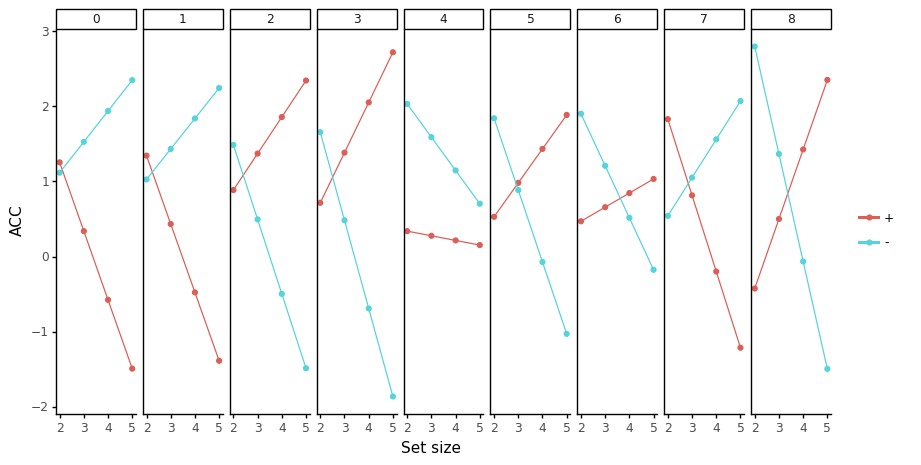

<ggplot: (152499095676)>

In [39]:
g = (gg.ggplot(RLWM_ns_long, gg.aes('ns', 'value', color='PlusMinus'))
     + gg.geom_point()
     + gg.geom_line(gg.aes(group='PlusMinus'))
     + gg.labs(x='Set size', y='ACC', color='')
     + gg.facet_grid('~ PC')
    )
g